# Show how to access the results of running AOS loop

The result of running

    python /project/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst comcam --numOfProc 55 --boresightDeg 0.03 -0.02 --rotCam 0 --skyFile /project/scichris/aos/rotation_DM-31532/comCam_grid.txt --output /project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/
    
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from lsst.daf import butler as dafButler
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [3]:
repoDir = '/project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/phosimData/' 

butler = dafButler.Butler(repoDir)
registry = butler.registry

instrument='LSSTComCam'
iterN=0
collection=f'ts_phosim_90060{iterN}1'
detector="R22_S01"


dataId0 = dict(instrument=instrument)
dataset = next(iter(butler.registry.queryDatasets(
                        datasetType='postISRCCD',
                        dataId=dataId0, 
                        collections=[collection]  )
                   ))

expN = dataset.dataId["exposure"]

# construct a dataId  for postISR 
dataId = {'detector':detector, 'instrument':instrument,
              'exposure':expN}
print(dataId)

# read the postISR exposure 
postIsrExp = butler.get('postISRCCD', dataId,
               collections=[collection])

# construct a dataId for zernikes and donut catalog:
# switch exposure to visit 
detector="R22_S01"
dataId = {'detector':detector, 'instrument':instrument,
          'visit':expN}
# the raw Zernikes 
zkRaw =  butler.get('zernikeEstimateRaw', dataId=dataId,
                        collections=[collection])

# the donut source catalog 
srcCat= butler.get('donutCatalog', dataId=dataId, collections=[collection])

# the donut stamps
extraFocalStamps = butler.get('donutStampsExtra', 
                          dataId=dataId, 
                          collections=[collection])  

{'detector': 'R22_S01', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}


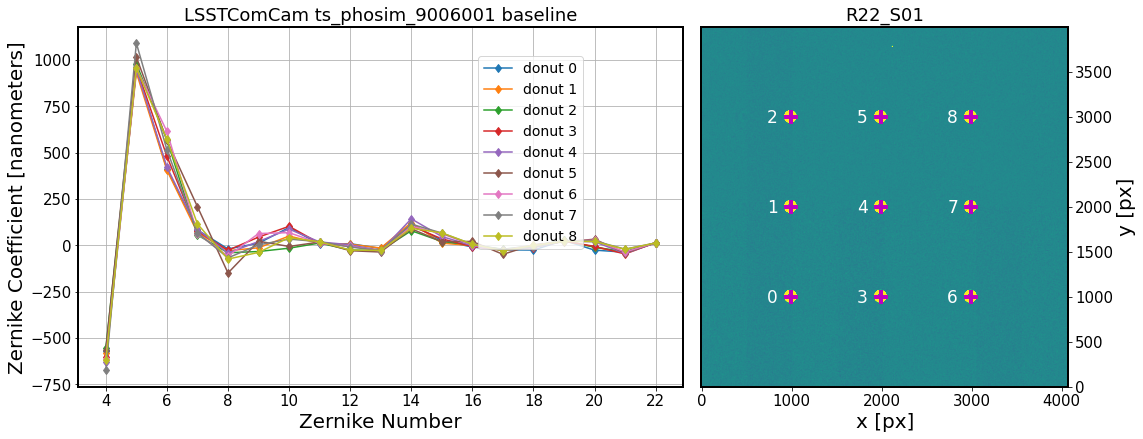

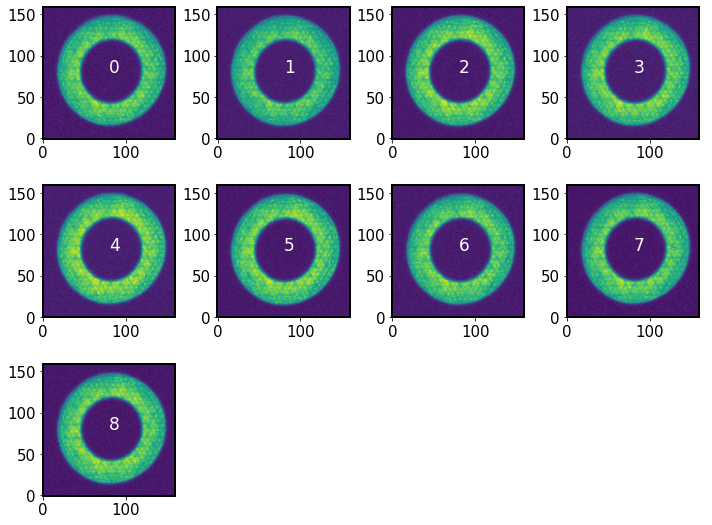

In [6]:
%matplotlib inline
from astropy.visualization import ZScaleInterval
# since we queried by detector, sources in that catalog are 
# only for that detector., and its a pandas Df 
exposureName = postIsrExp.getDetector().getName()
#expCatalog = srcCat.query(f'detector == "{exposureName}"')

# plot the figure ...   
fig = plt.figure(figsize=(14, 5))

####################################
### left - plot the fit results  ###
#################################### 

#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,0.6,1])  

for i in range(len(zkRaw)):
    ax1.plot(np.arange(4, 23),1000*zkRaw[i], 
             '-d', label=f'donut {i}')

ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()
titleAdd = 'baseline'
ax1.set_title(f'{instrument} {collection} {titleAdd}', fontsize=18)


###############################################
### right - plot the postISR image ###
###############################################

ax2 = fig.add_axes([0.6,0,0.4,1])
exposure_intra = postIsrExp
zscale = ZScaleInterval()
data = exposure_intra.image.array
vmin, vmax = zscale.get_limits(data)

ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)

nrows = len(srcCat)

xs  = list(srcCat.centroid_x)
ys = list(srcCat.centroid_y)
for i in range(nrows):

    x = xs[i]
    y = ys[i]

    # plot the cross marking that the donut was used 
    ax2.scatter(x,y,s=200,marker='+',c='m', lw=4)

    # plot the donut number on the plot 
    xtext,ytext = x,y
    ytext -= 60
    if xtext+100 > 4096:
        xtext -= 250
    if len(str(i))>1: # move to the left label thats too long 
        #print(i, 'moving')
        xtext -=340 
    else:
        xtext -=260
    ax2.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
ax2.yaxis.tick_right()
ax2.set_xlabel('x [px]')
ax2.set_ylabel('y [px]')
ax2.yaxis.set_label_position("right")
ax2.set_title(f'{exposureName}')

plt.show()
# plot donuts on a separate figure 
nDonuts = len(extraFocalStamps)
ncols=4
nrows= nDonuts//ncols
if nrows*ncols<nDonuts:
    nrows+=1
fig,axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
ax = np.ravel(axs)
for i in range(nDonuts):
    donut = extraFocalStamps[i]
    ax[i].imshow(donut.stamp_im.image.array, origin='lower')
    ax[i].text(80,80, f'{i}', fontsize=17, c='white')
fig.subplots_adjust(hspace=0.35)  

# if there are more axes than donuts,
# turn off the extra axes 
ncells = nrows*ncols
if ncells > nDonuts:
    for axis in ax[nDonuts:]:
        axis.axis("off")
